## Логистическая регрессия

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['lines.markersize'] = 6

Реализуйте обучение логистической регрессии с $L^1$ и $L^2$ регуляризацией с помощью метода Stochastic Gradient Descent (SGD)

#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

[[0.77790826]
 [0.35285082]
 [0.08648326]]
[37.121471   -8.29911368  7.13966947]


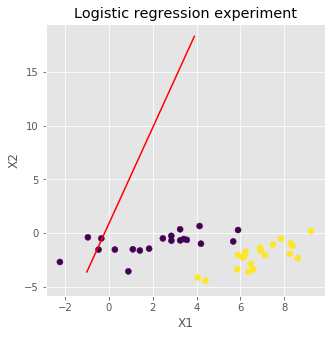

[[ 6.58236538 -3.38888142  1.        ]
 [ 5.89054707 -2.0358375   1.        ]
 [ 4.04769195 -4.13355706  1.        ]
 [ 6.35818965 -3.60481493  1.        ]
 [ 7.12594444 -2.05472758  1.        ]
 [ 4.40978894 -4.41779892  1.        ]
 [ 6.92391847 -1.64930972  1.        ]
 [ 5.8501631  -3.38692857  1.        ]
 [ 6.18321237 -2.16434417  1.        ]
 [ 8.37422282 -1.16751883  1.        ]
 [ 9.21708556  0.19627431  1.        ]
 [ 8.25374151 -1.91927711  1.        ]
 [ 6.47440821 -2.86766705  1.        ]
 [ 6.09634585 -2.25030337  1.        ]
 [ 8.2955332  -0.96140516  1.        ]
 [ 6.90486971 -1.36407422  1.        ]
 [ 6.23219154 -1.72642635  1.        ]
 [ 7.4810031  -1.07313477  1.        ]
 [ 7.85162355 -0.51861916  1.        ]
 [ 8.61306624 -2.33420641  1.        ]
 [-0.46709348 -1.53705539  1.        ]
 [ 4.13775091  0.65772903  1.        ]
 [ 0.27681646 -1.53146238  1.        ]
 [ 5.89142576  0.28653776  1.        ]
 [ 2.85456517 -0.70206909  1.        ]
 [ 1.09567063 -1.50669412

In [ ]:
from sklearn.metrics import zero_one_loss
from sklearn.base import BaseEstimator, ClassifierMixin
import math
import random

# gradients = 2. / m * X_b.T.dot(X_b.dot(theta) - y)
# theta_old = theta
# theta = theta - alpha * gradients
# dist = np.linalg.norm(theta - theta_old)
# if dist < eps:
#     break

# def predict(x, w):
#     return np.sign(x.dot(w))

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """

    regularisation_algorithms = ['l1', 'l2', None]
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, penalty=None):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch

        if penalty in self.regularisation_algorithms:
            self.penalty = penalty
            self.reg_function = self.__get_regularisation_function(penalty)
        else:
            raise AttributeError('Unknown regularisation algorithm {0}'.format(penalty))

    def __get_regularisation_function(self, penalty):
        if penalty == 'l1':
            return self.__l1_regularisation
        if penalty == 'l2':
            return self.__l2_regularisation
        else:
            return self.__none_regularisation
        return 1

    def __l1_regularisation(self, y, margin):
        return self.C * abs(y - margin)

    def __l2_regularisation(self, y, margin):
        return self.C * (y - margin) ** 2

    def __none_regularisation(self, _y, _margin):
        return 0.0

    def fit(self, X, y):
        '''
        Обучение модели
        '''
        (length, dims) = X.shape
        self.dimensions = dims + 1
        self.collection_len = length
        self.collection = self.__add_c_coefficient(X, length)
        self.function_values = y
        self.theta = self.__get_random_theta(self.dimensions)
        self.final_theta = 0

        self.__gradient_descent()
        
        return self

    def __add_c_coefficient(self, x, length):
        median_values = [np.median(x[:,i]) for i in range(self.dimensions - 1)]
        fill_value = np.max(median_values)
        return np.hstack([x, np.full((length, 1), 1)])

    def __gradient_descent(self):
        theta = self.theta
        for epoch in range(self.max_epoch):
            p = np.random.permutation(len(self.collection))
            # print("Epoch {0}".format(epoch))
            for index in p:
                # print("before theta {0}".format(theta.reshape((1,3))))
                xi = self.collection[index]
                yi = self.function_values[index]
                margin = self.__margin(theta, xi)
                sigma = self.__sigmoid(margin)
                gradient = (self.alpha * sigma * xi * yi + self.reg_function(yi, sigma)) / self.collection_len
                gradient = gradient.reshape((self.dimensions, 1))
                # print('yi {0} yhat {1} regularisation {2} Gradient {3} '.format(yi, yhat, self.reg_function(yi, yhat), gradient.reshape((1,3))))
                theta = np.add(theta, gradient)
                # print("id: {0} sigma {1} margin {2} gradient {3}, regularisation {4}".format(index, round(sigma, 4), round(margin, 4), gradient.reshape((1, 3)), self.reg_function(yi, sigma)))

            # self.print_theta(theta)

        self.final_theta = theta.reshape(1, self.dimensions)[0]
        return True

    def print_theta(self, theta):
        x_naive = np.arange(-1, 4, 0.1)
        [a, b, c] =theta.reshape(1, self.dimensions)[0]
        y_naive = -1 * (a / b) * x_naive - (c / b)
        plt.plot(x_naive, y_naive, c='g', label='way to optimal decision')
        return

    def __get_random_theta(self, dim):
        return np.array([random.random() for _ in range(dim)]).reshape(dim, 1)

    def __margin(self, theta, x):
        x = x.reshape((1, self.dimensions))
        margin = x.dot(theta)[0][0]
        # print('x {0} margin {1}, theta {2}'.format(x, margin, theta))
        return margin

    def __sigmoid(self, z):
        sigmoid = 1 / (1 + np.exp(-z))
        return sigmoid
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
    
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''

        
        return y_hat_proba

classifier = MySGDClassifier(C=0.5, alpha=1, max_epoch=10, penalty='l2')

np.random.seed(1)

size = 20

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(size, 2) + np.array([7, 5]), C1)
gauss2 = np.dot(np.random.randn(size, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
Y = np.r_[np.ones(size), np.zeros(size)]
classifier.fit(X, Y)

x_naive = np.arange(-1, 4, 0.1)
print(classifier.theta)
print(classifier.final_theta)
[a, b, c] = classifier.final_theta
# print('Theta {0}'.format(classifier.theta))
y_naive = -1 * (a / b) * x_naive - (c / b)
plt.plot(x_naive, y_naive, c='red', label='descision boundary naive')

plt.scatter(X[:, 0], X[:, 1], c=Y + 1)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Logistic regression experiment')
plt.show()
print(classifier.collection)



## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

In [542]:
# np.random.seed(0)
# 
# C1 = np.array([[0., -0.8], [1.5, 0.8]])
# C2 = np.array([[1., -0.7], [2., 0.7]])
# gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
# gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)
# 
# X = np.vstack([gauss1, gauss2])
# y = np.r_[np.ones(200), np.zeros(200)]
# 
# plt.scatter(X[:,0], X[:,1], c=y)
# import math
# ar1 = np.array([[1],[2],[3]])
# ar2 = np.array([[5],[5],[5]])
# print(ar1)
# print(ar.reshape((1,3)))
# print(ar + 0.4)
# print(dir(math))
# C1 = np.array([[0., -0.8], [1.5, 0.8]])
# C2 = np.array([[1., -0.7], [2., 0.7]])
# [a, b, c] = c.theta
# print([a, b, c] )



# print(np.random.randn(3, 1))
ar = X[:, 0]
print(ar)
print(np.max(ar))
print(dir(np))


[ 6.58236538  5.89054707  4.04769195  6.35818965  7.12594444 -1.15817348
  0.40947409  0.43398691 -0.42814504  2.70784417]
7.125944436783885
['ALLOW_THREADS', 'AxisError', 'BUFSIZE', 'CLIP', 'ComplexWarning', 'DataSource', 'ERR_CALL', 'ERR_DEFAULT', 'ERR_IGNORE', 'ERR_LOG', 'ERR_PRINT', 'ERR_RAISE', 'ERR_WARN', 'FLOATING_POINT_SUPPORT', 'FPE_DIVIDEBYZERO', 'FPE_INVALID', 'FPE_OVERFLOW', 'FPE_UNDERFLOW', 'False_', 'Inf', 'Infinity', 'MAXDIMS', 'MAY_SHARE_BOUNDS', 'MAY_SHARE_EXACT', 'MachAr', 'ModuleDeprecationWarning', 'NAN', 'NINF', 'NZERO', 'NaN', 'PINF', 'PZERO', 'PackageLoader', 'RAISE', 'RankWarning', 'SHIFT_DIVIDEBYZERO', 'SHIFT_INVALID', 'SHIFT_OVERFLOW', 'SHIFT_UNDERFLOW', 'ScalarType', 'Tester', 'TooHardError', 'True_', 'UFUNC_BUFSIZE_DEFAULT', 'UFUNC_PYVALS_NAME', 'VisibleDeprecationWarning', 'WRAP', '_NoValue', '__NUMPY_SETUP__', '__all__', '__builtins__', '__cached__', '__config__', '__doc__', '__file__', '__git_revision__', '__loader__', '__mkl_version__', '__name__', '__pa

In [5]:
model = MySGDClassifier()
model.fit(X, y)

MySGDClassifier(C=1, alpha=0.01, max_epoch=10, penalty=None)

In [22]:
print(X)

[[ 5.10023581e+00 -2.69111611e+00]
 [ 7.86133980e+00 -5.90275828e-01]
 [ 3.03408318e+00 -3.87586870e+00]
 [ 4.27296419e+00 -2.48115650e+00]
 [ 5.11589775e+00 -1.18894612e+00]
 [ 6.68141026e+00 -5.51816051e-01]
 [ 4.68251252e+00 -2.11149017e+00]
 [ 5.00051149e+00 -1.68815112e+00]
 [ 4.19226260e+00 -2.95938987e+00]
 [ 3.21885639e+00 -2.53373075e+00]
 [ 5.48042789e+00  9.65286729e-01]
 [ 3.38675247e+00 -2.88528098e+00]
 [ 2.31845149e+00 -4.57929624e+00]
 [ 4.21922422e+00 -1.78635389e+00]
 [ 6.70403815e+00 -1.65073636e+00]
 [ 5.06724378e+00 -1.42142792e+00]
 [ 1.52880530e+00 -2.47440858e+00]
 [ 4.73452345e+00 -1.19659111e+00]
 [ 6.30356977e+00 -1.62232867e+00]
 [ 4.04654587e+00 -1.53198075e+00]
 [ 2.36997309e+00 -1.89717198e+00]
 [ 7.42616309e+00  1.32563647e+00]
 [ 3.84288855e+00 -1.54273770e+00]
 [ 5.66623553e+00  2.42285727e-02]
 [ 4.18088958e+00 -4.79073946e-01]
 [ 5.08035375e+00 -5.74104753e-01]
 [ 2.72905172e+00 -2.13586164e+00]
 [ 5.14249781e+00 -1.23478872e+00]
 [ 4.95370785e+00 -1

## Анализ сходимости

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/эпохи (выбрать одно) для разных `alpha`.

In [9]:
print(np.ones((10, 1)))

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
